# Bayes' Rule and Neural Network

- Assumption: 2 class-conditional densities share the same covariance matrix
- Bayesian (closed form) vs. neural network (logistic regression trained using gradient descent)
- Whether the gradient-descent solutions approaches closed-form solution in terms of accuracy and solution similarity

## Logistic function motivation

Suppose each output node of our single-layer network deals with a binary classification problem. For the output node $y_k$, $p(C^k_1|x)$ denotes the probability that $x$ belongs to $C^k_1$ and $1-p(C^k_1|x)$ denotes the probability that $x$ belongs to $C^k_2$. Here, $C^k_1$ and $C^k_2$ represents the two states of the $k$th binary output variable.

Intuitively, we can train our single-layer network directly on a dataset with examples as inputs and posterior probabilities as outputs. However, note that probabilities are bounded by $[0, 1]$. Since this assumption is inherently built into the neural network, there may be times when the network outputs values below zero or above one. What should one do when the network outputs 1.01? There's no clear answers.

Therefore, we seek a way of representing a posterior probability in terms of another quantity (let's call it $a$) which is (1) unbounded ($a \in [-\infty, \infty]$) and (2) can be easily converted back to a probability. Recall the Bayes' rule, that the posterior probability is equal to the RHS:

$$p(C_1|x)=\frac{p(x|C_1)P(C_1)}{p(x|C_1)P(C_1) + p(x|C_2)P(C_2)}$$

So our real challenge is to represent the RHS in terms of $a$. Let's consider some unrelated ideas just for inspiration:
- ratios between two positive numbers are bounded by $[0, \infty]$
- log(ratios) between two positive numbers are bounded by $[-\infty, \infty]$

To obtain a ratio, we divide both the numerator and the denominator of the RHS by the numerator:
$$p(C_1|x)=\frac{1}{1 + \frac{p(x|C_2)P(C_2)}{p(x|C_1)P(C_1}}$$

To obtain a log(ratio), we use the trick $n=\exp\{ \log(n) \}$ for $n\in\mathbb{R}$:
$$p(C_1|x)=\frac{1}{1 + \exp \{ a \} }$$ where we have defined $a$ to be $\log( \frac{p(x|C_2)P(C_2)}{p(x|C_1)P(C_1)} )$.

Since we are evaluating $p(C_1|x)$ not $p(C_2|x)$, we would like $p(C_1|x)$ to have a positive gradient with respect to $p(x|C_1)P(C_1)$. Currently, this gradient is negative, which does not pose any serious problems except that it is counter-intuitive. To do this, we simply change the log(ratio) to:
$$p(C_1|x)=\frac{1}{1 + \exp \{ -a \} }$$ where we have defined $a$ to be $- \log( \frac{p(x|C_2)P(C_2)}{p(x|C_1)P(C_1)} )=\log( \frac{p(x|C_1)P(C_1)}{p(x|C_2)P(C_2)} )$.

The function $p(C_1|x)=\frac{1}{1 + \exp \{ -a \} }$ is called the logistic sigmoid function.

Now we only seek to model the quantity $\log( \frac{p(x|C_1)P(C_1)}{p(x|C_2)P(C_2)} )$. To do this, we simply maximizes it as much as we can. But before optimizing it directly using gradient descent, let's substitute in the expressions for the two class-conditional distributions and see what form it takes. If this form matches the form of a single-layer network, then we are more confident that our single-layer network can handle the tasks of evaluating posterior probabilities.

## Generate data

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from seaborn import kdeplot
import matplotlib.pyplot as plt

In [2]:
class GMM():
    
    def __init__(self): 
        self.class_props = [0.3, 0.7]
        self.class_conditional_1 = multivariate_normal(mean=[1, 1], cov=0.2)
        self.class_conditional_2 = multivariate_normal(mean=[2, 1], cov=0.2)
     
    def sample_with_labels(self, n):

        comp_indices = np.random.choice([0, 1], size=n, p=self.class_props)

        comp_1_indices = np.where(comp_indices == 0)[0]
        comp_1_samples_all = self.class_conditional_1.rvs(n)
        if comp_1_samples_all.ndim == 1:
            comp_1_samples_all = np.expand_dims(comp_1_samples_all, 0)
        comp_1_samples = comp_1_samples_all[comp_1_indices]
    
        comp_2_indices = np.where(comp_indices == 1)[0]
        comp_2_samples_all = self.class_conditional_2.rvs(n)
        if comp_2_samples_all.ndim == 1:
            comp_2_samples_all = np.expand_dims(comp_2_samples_all, 0)
        comp_2_samples = comp_2_samples_all[comp_2_indices]

        return comp_1_samples, comp_2_samples
    
    def sample(self, n):
        comp_1_samples, comp_2_samples = self.sample_with_labels(n)
        samples = np.concatenate([comp_1_samples, comp_2_samples])
        np.random.shuffle(samples)
        return samples
    
    def pdf(self, point):
        p = np.sum(self.class_props * np.array([self.class_conditional_1.pdf(point), self.class_conditional_2.pdf(point)]))
        return p

In [3]:
gmm = GMM()

In [4]:
comp_1_samples, comp_2_samples = gmm.sample_with_labels(n=500)
print(comp_1_samples.shape, comp_2_samples.shape)

(153, 2) (347, 2)


In [5]:
point = np.array([1, 1.0])

In [6]:
FEATURE_1 = np.s_[:,0]
FEATURE_2 = np.s_[:,1]

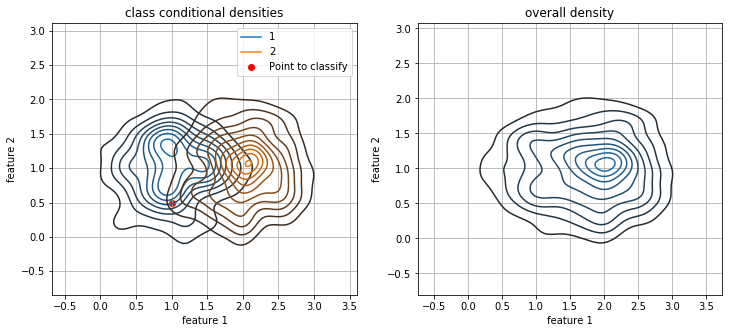

In [7]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121)

kdeplot(comp_1_samples[FEATURE_1], comp_1_samples[FEATURE_2], label=1, ax=ax1)
kdeplot(comp_2_samples[FEATURE_1], comp_2_samples[FEATURE_2], label=2, ax=ax1)

point = np.array([[1, 0.5]])
plt.scatter(point[FEATURE_1], point[FEATURE_2], label='Point to classify', color='red')

ax1.set_title('class conditional densities')
ax1.set_xlabel('feature 1'); ax1.set_ylabel('feature 2')
ax1.legend(); ax1.grid()

ax2 = fig.add_subplot(122)

samples = np.concatenate([comp_1_samples, comp_2_samples])
kdeplot(samples[FEATURE_1], samples[FEATURE_2], ax=ax2)

ax2.set_title('overall density')
ax2.set_xlabel('feature 1'); ax2.set_ylabel('feature 2')
ax2.grid()

plt.show()

## Closed-form solution in Bayesian

For a single data point:

$$p(C_k|x)=\frac{p(x|C_k)P(C_k)}{p(x)}$$

In [8]:
# prior
P_C1, P_C2 = gmm.class_props
print(P_C1, P_C2)

0.3 0.7


In [9]:
# class conditional
p_x_C1 = gmm.class_conditional_1.pdf(point)
p_x_C2 = gmm.class_conditional_2.pdf(point)
print(p_x_C1, p_x_C2)

0.4259475109761324 0.03496390085232893


In [10]:
# normalization factor
p_x = gmm.pdf(point)
print(p_x)

0.15225898388946996


In [11]:
# posterior
p_C1_x = (p_x_C1 * P_C1) / p_x
p_C2_x = (p_x_C2 * P_C2) / p_x
print(p_C1_x, p_C2_x)

0.8392559179667369 0.16074408203326312


In [12]:
def bayes_rule(gmm, point, klass):
    if klass == 1:
        return (gmm.class_conditional_1.pdf(point) * gmm.class_props[0]) / gmm.pdf(point) 
    elif klass == 2:
        return (gmm.class_conditional_2.pdf(point) * gmm.class_props[1]) / gmm.pdf(point) 

In [13]:
print(bayes_rule(gmm, point, klass=1))
print(bayes_rule(gmm, point, klass=2))

0.8392559179667369
0.16074408203326312


For 1000 data points:

In [14]:
# generate some test samples
# c1_test_samps: test samples generated by component 1
c1_test_samps, c2_test_samps = gmm.sample_with_labels(n=5000)
print(c1_test_samps.shape, c2_test_samps.shape)

(1491, 2) (3509, 2)


In [15]:
def acc(preds, decision_func):
    return np.mean(decision_func(preds))

In [48]:
preds = np.zeros((len(c1_test_samps), ))
for i, samp in enumerate(c1_test_samps):
    posterior = bayes_rule(gmm, samp, klass=1)
    if posterior > 0.5:
        preds[i] = 1

In [49]:
bayesian_baseline_acc_c1 = acc(preds, decision_func=lambda pred : pred == 1)
print(bayesian_baseline_acc_c1)

0.7639168343393695


In [50]:
preds = np.zeros((len(c2_test_samps), ))
for i, samp in enumerate(c2_test_samps):
    posterior = bayes_rule(gmm, samp, klass=2)
    if posterior > 0.5: preds[i] = 1

In [51]:
bayesian_baseline_acc_c2 = acc(preds, decision_func=lambda pred : pred == 1)
print(bayesian_baseline_acc_c2)

0.9407238529495583


## Closed-form NN-style solution in Bayesian
First written: Sunday, March 15th, 2020, Spring Break, Cognition Lab @ Carleton College, Good mood

If we substitude 
$p\left(\mathbf{x} | C_{k}\right)=\frac{1}{(2 \pi)^{d / 2}|\mathbf{\Sigma}|^{1 / 2}} \exp \left\{-\frac{1}{2}\left(\mathbf{x}-\boldsymbol{\mu}_{k}\right)^{\mathrm{T}} \mathbf{\Sigma}^{-1}\left(\mathbf{x}-\boldsymbol{\mu}_{k}\right)\right\}$
into $a = \log( \frac{p(x|C_1)P(C_1)}{p(x|C_2)P(C_2)} )$, we obtain:

<img src='closed_form_solution.png' width=600>

Posterior probabilities are computed using $p(C_1|x)=\frac{1}{1 + \exp \{ -a \} }$, or $p(C_1|x)=\frac{1}{1 + \exp \{ \vec{w}^T \vec{x} + x_0 \} }$ (this is what's being done by the code below).

In [23]:
# define mu1
mu1 = np.array([
    [1],
    [1]
])

# define mu2
mu2 = np.array([
    [2],
    [1]
])

In [24]:
# define shared covariance matrix
cov = np.array([
    [0.2, 0],
    [0, 0.2]
])

In [25]:
# define prior probabilities
P_C1, P_C2 = gmm.class_props
print(P_C1, P_C2)

0.3 0.7


In [26]:
# compute \vec{w} and w0 using equation 3.18 and 3.19 respectively
w = np.linalg.inv(cov) @ (mu1 - mu2)
w0 = (-0.5) * mu1.T @ np.linalg.inv(cov) @ mu1 + (0.5) * mu2.T @ np.linalg.inv(cov) @ mu2 + np.log(P_C1 / P_C2)

In [27]:
print(w, w0)

[[-5.]
 [ 0.]] [[6.65270214]]


In [28]:
# defined utility functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [29]:
c1_test_classifications = sigmoid(w.T @ c1_test_samps.T + w0)
acc(c1_test_classifications, decision_func=lambda preds : preds > 0.5)

0.7639168343393695

In [30]:
c2_test_classifications = sigmoid(w.T @ c2_test_samps.T + w0)
acc(c2_test_classifications, decision_func=lambda preds : preds < 0.5)

0.9407238529495583

Accuracy on class 2 is expected to be higher since its prior probability is greater - there are simply more samples from class 2 (70%, see `P_C1`).

These accuracies are not expected to be exceeded by the gradient-descent approach.

## Gradient-descent solution

In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [32]:
class SingleLayerNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=2, out_features=1, bias=True),
            nn.Sigmoid()
        )
        
    def forward(self, xs):
        xs = self.main(xs)
        return xs.view(xs.size(0))

In [201]:
def get_model():
    model = SingleLayerNetwork()
    return model, optim.Adam(model.parameters(), lr=0.06)

In [202]:
loss_fn = nn.BCELoss()

In [203]:
test_samps = torch.from_numpy(np.concatenate([c1_test_samps, c2_test_samps]))
# train_labels = torch.from_numpy(np.concatenate([np.ones((len(c1_test_samps), 1)), np.zeros((len(c2_test_samps), 1))]))
test_labels = torch.from_numpy(np.concatenate(
    [
        np.zeros(len(c1_test_samps)),
        np.ones(len(c2_test_samps))
    ]
))

In [204]:
np.random.seed(23)
train_samps_c1, train_samps_c2 = gmm.sample_with_labels(n=5000)
print(train_samps_c1.shape, train_samps_c2.shape)
train_samps = torch.from_numpy(np.concatenate([train_samps_c1, train_samps_c2]))
train_labels = torch.from_numpy(np.concatenate(
    [
        np.zeros(len(train_samps_c1)),
        np.ones(len(train_samps_c2)),
    ]
))

(1536, 2) (3464, 2)


In [205]:
test_ds = TensorDataset(test_samps, test_labels)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=True)

In [206]:
train_ds = TensorDataset(train_samps, train_labels)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True)

In [207]:
def get_preds_of_c1_samps(yhatb, yb):
    return yhatb.detach().numpy()[np.where(yb.numpy() == 0)[0]]

In [208]:
def get_preds_of_c2_samps(yhatb, yb):
    return yhatb.detach().numpy()[np.where(yb.numpy() == 1)[0]]

In [209]:
def get_acc_of_c1_samps(yhatb, yb):
    return np.mean(get_preds_of_c1_samps(yhatb, yb) < 0.5)

In [210]:
def get_acc_of_c2_samps(yhatb, yb):
    return np.mean(get_preds_of_c2_samps(yhatb, yb) > 0.5)

Bayesian baseline:
- C1 acc: 0.7579617834394905
- C2 acc: 0.9256559766763849

In [211]:
class MetricCallback():
    
    def on_train_begin(self):
        self.value_per_epoch = []
        
    def on_epoch_begin(self):
        self.num_batches = 0
        self.weighted_values = []
        
    def on_loss_end(self, value, bs):
        self.weighted_values.append(value * bs)
        self.num_batches += bs
        
    def on_epoch_end(self):
        self.value_per_epoch.append(np.sum(self.weighted_values) / self.num_batches)

In [234]:
model, opt = get_model()
acc_cb_c1 = MetricCallback()
acc_cb_c2 = MetricCallback()

acc_cb_c1.on_train_begin()
acc_cb_c2.on_train_begin()

for i in range(100):
    
    acc_cb_c1.on_epoch_begin()
    acc_cb_c2.on_epoch_begin()
    
    model.train()
    for xb, yb in train_dl:
        
        yhatb = model(xb.float())
        loss = loss_fn(yhatb, yb.float())
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    model.eval()
    for xb, yb in test_dl:
        
        yhatb = model(xb.float())
        
        bs_c1 = np.sum(yb.numpy() == 0)
        if not bs_c1 == 0:
            temp_acc_c1 = get_acc_of_c1_samps(yhatb, yb)
        else:
            temp_acc_c1 = 1.0
        acc_cb_c1.on_loss_end(temp_acc_c1, bs_c1)
        
        bs_c2 = np.sum(yb.numpy() == 1)
        if not bs_c2 == 0:
            temp_acc_c2 = get_acc_of_c2_samps(yhatb, yb)
        else:
            temp_acc_c2 = 1.0
        acc_cb_c2.on_loss_end(temp_acc_c2, bs_c2)
        
    acc_cb_c1.on_epoch_end()
    acc_cb_c2.on_epoch_end()

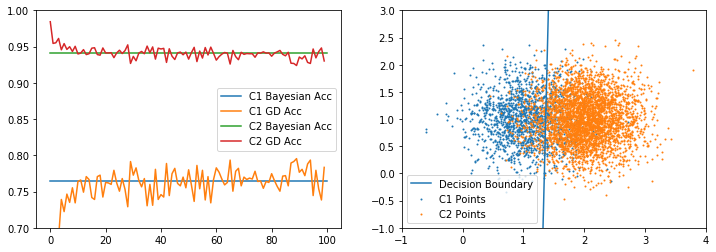

In [262]:
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)

plt.plot([0, 100], [bayesian_baseline_acc_c1, bayesian_baseline_acc_c1], label='C1 Bayesian Acc')
plt.plot(acc_cb_c1.value_per_epoch, label='C1 GD Acc')

plt.plot([0, 100], [bayesian_baseline_acc_c2, bayesian_baseline_acc_c2], label='C2 Bayesian Acc')
plt.plot(acc_cb_c2.value_per_epoch, label='C2 GD Acc')

plt.legend()
plt.ylim(0.7, 1.0)

# ========== second subplot

fig.add_subplot(122)

weight, bias = list(model.parameters())
weight, bias = weight.detach().numpy()[0], bias.detach().numpy()

xs = np.array([-1, 4])

# weight[0] * feature_1 + weight[1] * feature_2 + bias = 0
# feature_2 = (-weight[0] * feature_1 - bias) / weight[1]

ys = (-weight[0] * xs - bias) / weight[1] 
plt.scatter(c1_test_samps[FEATURE_1], c1_test_samps[FEATURE_2], s=1, label='C1 Points')
plt.scatter(c2_test_samps[FEATURE_1], c2_test_samps[FEATURE_2], s=1, label='C2 Points')
plt.plot(xs, ys, label='Decision Boundary')

plt.legend()

plt.xlim(-1, 4)
plt.ylim(-1, 3)

plt.show()